In [136]:
import sys
import subprocess
import pkg_resources
import statsmodels._version

if statsmodels._version.get_versions()['version'] != '0.11.1':
  !pip install --upgrade statsmodels

required = {'pmdarima'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%cd "/content/drive/My Drive/Colab Notebooks/Time_Series_Projects/Data"

/content/drive/My Drive/Colab Notebooks/Time_Series_Projects/Data


In [138]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [139]:
df = pd.read_csv('RestaurantVisitors.csv',parse_dates=True,index_col = 'date')

In [140]:
df.index.freq = 'D'

In [141]:
df = df.dropna()

In [142]:
cols = [ 'rest1', 'rest2', 'rest3',  'rest4', 'total']
for col in cols:
  df[col] = df [col].astype(int)

In [143]:
df.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


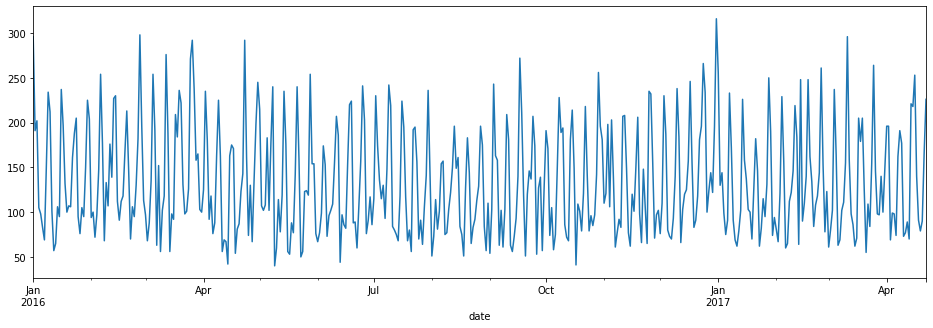

In [144]:
df['total'].plot(figsize=(16,5));

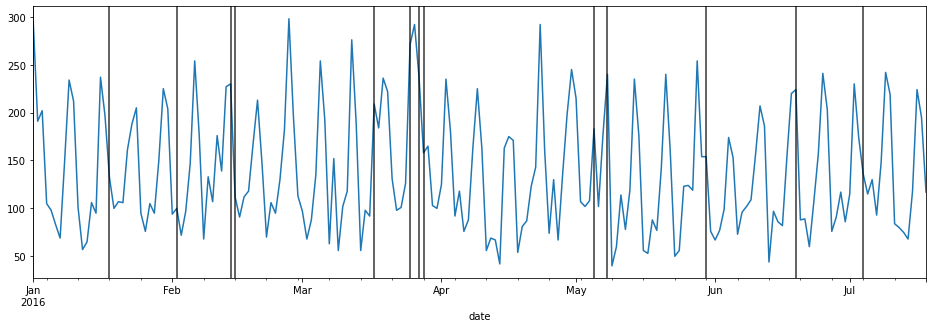

In [145]:
ax  = df['total'].iloc[:200].plot(figsize=(16,5));
holidays = df.query('holiday==1').index

for day in holidays:
  ax.axvline(x=day,color='k',alpha=0.8);


ETS Decomposition

In [146]:
from statsmodels.tsa.seasonal import seasonal_decompose

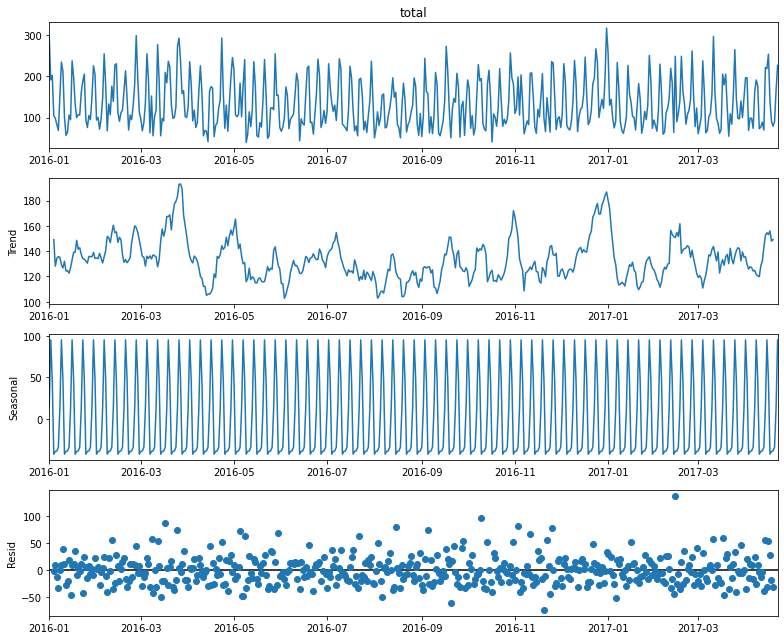

In [147]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
seasonal_decompose(df['total'],model='add').plot();

Train Test Split

In [148]:
len(df)

478

In [149]:
train = df.iloc[:436]
test = df.iloc[436:]

In [151]:
from pmdarima import auto_arima

In [152]:
auto_arima_results = auto_arima(df['total'],seasonal=True,m=7,method='nm',maxiter=1000,trace=True)

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(1,0,1,7) [intercept=True]; AIC=4724.630, BIC=4757.986, Time=7.037 seconds
Fit ARIMA(0,0,0)x(0,0,0,7) [intercept=True]; AIC=5269.484, BIC=5277.823, Time=0.135 seconds
Fit ARIMA(1,0,0)x(1,0,0,7) [intercept=True]; AIC=4916.749, BIC=4933.428, Time=2.132 seconds
Fit ARIMA(0,0,1)x(0,0,1,7) [intercept=True]; AIC=5049.644, BIC=5066.322, Time=0.893 seconds
Fit ARIMA(0,0,0)x(0,0,0,7) [intercept=False]; AIC=6126.084, BIC=6130.254, Time=0.045 seconds
Fit ARIMA(2,0,2)x(0,0,1,7) [intercept=True]; AIC=5032.559, BIC=5061.746, Time=3.716 seconds
Fit ARIMA(2,0,2)x(1,0,0,7) [intercept=True]; AIC=4885.410, BIC=4914.597, Time=6.598 seconds
Fit ARIMA(2,0,2)x(2,0,1,7) [intercept=True]; AIC=4730.695, BIC=4768.222, Time=10.506 seconds
Near non-invertible roots for order (2, 0, 2)(2, 0, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.991)
Fit ARIMA(2,0,2)x(1,0,2,7) [intercept=True]; AIC=4729.907, BI

In [153]:
print(auto_arima_results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  478
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -2353.208
Date:                             Sat, 04 Jul 2020   AIC                           4720.416
Time:                                     18:59:58   BIC                           4749.604
Sample:                                          0   HQIC                          4731.891
                                             - 478                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0040      0.049      0.082      0.934      -0.091       0.099
ar.L1          0.3182      

In [154]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [161]:
model = SARIMAX(train['total'],order = (1,0,0),seasonal_order = (2,0,0,7),enforce_invertibility=False).fit()

In [163]:
model2 = SARIMAX(train['total'],order = (1,0,2),seasonal_order = (1,0,1,7),enforce_invertibility=False).fit()

In [162]:
model.aic

4457.402658255681

In [165]:
model2.aic

4314.053918917745

In [166]:
start = len(train)
end = len(df)-1
predictions = model.predict(start = start,end = end).rename("SARIMA Model 1")
predictions = model2.predict(start = start,end = end).rename("SARIMA Model 2")

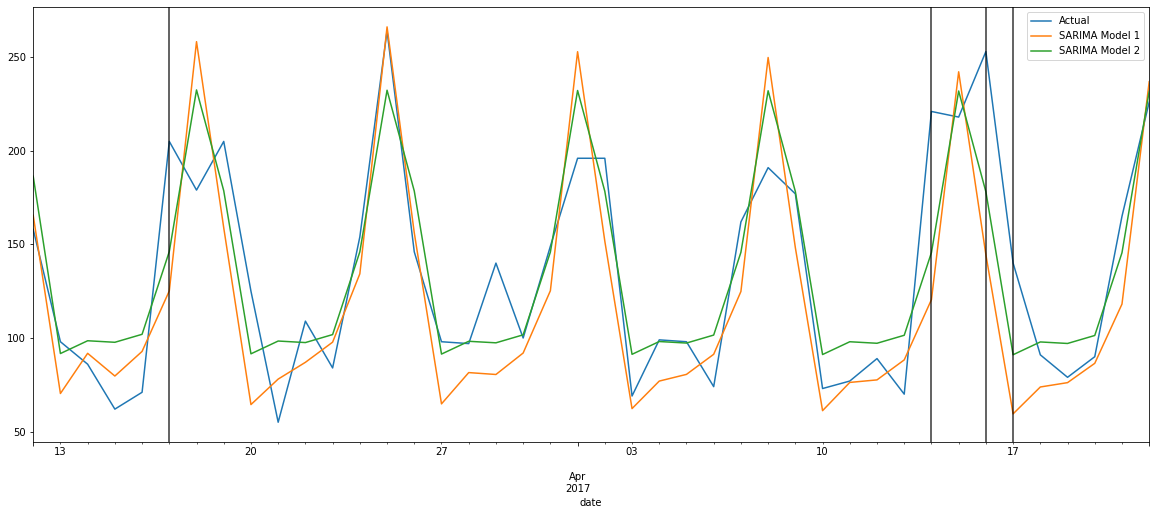

In [187]:
ax = test['total'].plot(legend = True,figsize=(20,8), label = 'Actual')
predictions.plot(legend = True)
predictions2.plot(legend = True)
for day in holidays:
  ax.axvline(x=day,color='k',alpha=0.8);

In [177]:
from statsmodels.tools.eval_measures import rmse

In [184]:
print(f"Model 1 RMSE: {rmse(test['total'],predictions):.0f}")
print(f"Model 2 RMSE: {rmse(test['total'],predictions2):.0f}")

Model 1 RMSE: 41
Model 2 RMSE: 31


In [188]:
test['total'].mean()

134.26190476190476